In [1]:
#Script para identificar determinantes de citações na base USPTO
#Renato Kogeyama

#09-15-2019
#O naive bayes tem algum problema com distribuicoes desbalanceadas
#o scikit learn tem um modulo que corrige count distributions com muitos zeros, o complementNB
#porem este nao esta disponivel na atual versao disponibilizada no HPC da FIU

#09-10-2019
#o trabalho pede uma abordagem mais sistematica e cuidadosa
#estou agrupando o codigo antigo comentado e vou comecar um novo codigo

#09-17-2018

#Alto uso de memoria - rodar no Amazon AWS 
#Notebook 2

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plot
from sklearn.metrics import roc_curve, auc
from scipy import stats
import datetime
import pylab

In [3]:
%matplotlib inline

In [4]:
# Read the file
# df=pd.read_table(r'/home/rkogeyam/PATENT_CITATION/df_w_pat_cit.csv', sep=',')

# o arquivo gerado em 190926 categoriza as variaveis type e kind, alem de trazer a data ja separada em dia, mes e ano
# df=pd.read_csv(r'/home/rkogeyam/PATENT_CITATION/df_w_pat_cit_191003.csv', sep=',', index_col=0 )

df=pd.read_csv('/home/rkogeyam/PATENT_CITATION/df_w_pat_cit_191003.csv', sep=',', index_col=0, usecols=[1,2,3,5,8,9,11,12,13,14,15])

# Identify null variables
pd.isnull(df).sum() > 0

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


type                  True
number                True
date                  True
kind                  True
num_claims            True
forward_citation     False
backward_citation    False
year                  True
month                 True
day                   True
dtype: bool

In [5]:
# print(df[df.isnull().any(axis=1)])

In [6]:
df=df.dropna()

In [7]:
# Generate a binary output for simpler tests
#df['citation_bi']=0
#df.loc[df.backward_citation>0, 'citation_bi']=1

# Convert categorical to binary
# df=pd.get_dummies(df, columns=['type', 'kind', 'country'])
df=pd.get_dummies(df, columns=['type', 'kind'])

df.describe()

,num_claims,forward_citation,backward_citation,year,month,day,type_TVPP,type_defensive publication,type_design,type_plant,...,kind_E1,kind_H,kind_H1,kind_I4,kind_I5,kind_P,kind_P2,kind_P3,kind_S,kind_S1
count,6.488250e+06,6.488250e+06,6.488250e+06,6.488250e+06,6.488250e+06,6.488250e+06,6.488250e+06,6.488250e+06,6.488250e+06,6.488250e+06,...,6.488250e+06,6.488250e+06,6.488250e+06,6.488250e+06,6.488250e+06,6.488250e+06,6.488250e+06,6.488250e+06,6.488250e+06,6.488250e+06
mean,1.414322e+01,2.184880e+00,1.121036e+00,2.002723e+03,6.590932e+00,1.564228e+01,4.623743e-07,7.844950e-05,8.677270e-02,3.820753e-03,...,1.405618e-03,3.054753e-04,4.192194e-05,7.844950e-05,4.623743e-07,1.276461e-03,1.757176e-03,7.871152e-04,3.230178e-02,5.447093e-02
std,1.200423e+01,1.755111e+01,7.449018e+00,1.132268e+01,3.402092e+00,8.827000e+00,6.799810e-04,8.856826e-03,2.815017e-01,6.169405e-02,...,3.746521e-02,1.747518e-02,6.474580e-03,8.856826e-03,6.799810e-04,3.570479e-02,4.188185e-02,2.804453e-02,1.768004e-01,2.269446e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,0.000000e+00,0.000000e+00,1.995000e+03,4.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.200000e+01,0.000000e+00,0.000000e+00,2.005000e+03,7.000000e+00,1.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+01,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+01,2.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,8.870000e+02,2.914000e+03,2.592000e+03,2.017000e+03,1.200000e+01,3.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [8]:
# df.columns.values

In [9]:
df.shape

(6488250, 29)

In [10]:
# df=df.fillna(0)

In [11]:
df.shape

(6488250, 29)

In [12]:
# data exploration

# outcome: citation count

# data with more than one citation
# exclude zeroes and ones
df2=df[df.backward_citation>1]
df2.shape

(528734, 29)

In [13]:
# dealing with outliers 

df3=df._get_numeric_data()

print("df3.shape")
print(df3.shape)

mean=df3.mean(axis=0)
std_dev=df3.std(axis=0)

threshold=3*std_dev

df3=df3[df3.backward_citation-mean.backward_citation<threshold.backward_citation]
df3=df3[df3.num_claims-mean.num_claims<threshold.num_claims]

df3.shape
(6488250, 27)


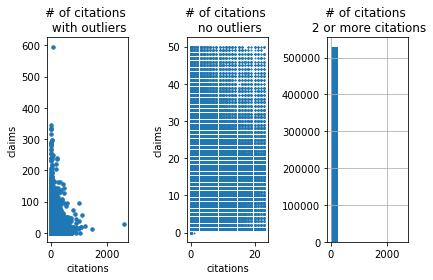

In [14]:
plot.subplot(1, 3, 1)
plot.title('# of citations \n with outliers')
plot.xlabel('citations') 
plot.ylabel('claims') 
plot.scatter(df2['backward_citation'], df2['num_claims'], s=12)

plot.subplot(1, 3, 2)
plot.title('# of citations \n no outliers')
plot.xlabel('citations') 
plot.ylabel('claims') 
plot.scatter(df3['backward_citation'], df3['num_claims'], s=1)

plot.subplot(1, 3, 3)
plot.title('# of citations \n 2 or more citations')
df2.backward_citation.hist()

plot.tight_layout() #diminui o overlap entre os graficos

In [15]:
# citations by type


In [16]:
# stats.probplot(df2.backward_citation, dist="norm", plot=pylab)
# pylab.show()

In [17]:
# stats.probplot(df3.backward_citation, dist="norm", plot=pylab)
# pylab.show()

In [18]:
df['num_claims']=df['num_claims'].astype(str).astype(float)

In [19]:
# Check the Dataset
def uniqueColValues(auxdf):
    for column in auxdf:
        print("{} | {} | {}".format(
            auxdf[column].name, len(auxdf[column].unique()), auxdf[column].dtype
        ))
        
uniqueColValues(df2)

number | 528734 | object
date | 2185 | object
num_claims | 212 | float64
forward_citation | 632 | float64
backward_citation | 518 | float64
year | 42 | float64
month | 12 | float64
day | 31 | float64
type_TVPP | 1 | float64
type_defensive publication | 2 | float64
type_design | 2 | float64
type_plant | 2 | float64
type_reissue | 2 | float64
type_statutory invention registration | 2 | float64
type_utility | 2 | float64
kind_A | 2 | float64
kind_B1 | 2 | float64
kind_B2 | 2 | float64
kind_E | 2 | float64
kind_E1 | 2 | float64
kind_H | 1 | float64
kind_H1 | 2 | float64
kind_I4 | 2 | float64
kind_I5 | 1 | float64
kind_P | 2 | float64
kind_P2 | 2 | float64
kind_P3 | 2 | float64
kind_S | 2 | float64
kind_S1 | 2 | float64


In [20]:
df.columns

Index(['number', 'date', 'num_claims', 'forward_citation', 'backward_citation',
       'year', 'month', 'day', 'type_TVPP', 'type_defensive publication',
       'type_design', 'type_plant', 'type_reissue',
       'type_statutory invention registration', 'type_utility', 'kind_A',
       'kind_B1', 'kind_B2', 'kind_E', 'kind_E1', 'kind_H', 'kind_H1',
       'kind_I4', 'kind_I5', 'kind_P', 'kind_P2', 'kind_P3', 'kind_S',
       'kind_S1'],
      dtype='object')

In [21]:
# # # Naive Bayes

# chosenColumns = ['num_claims','year']

# myX = df2.as_matrix(columns=chosenColumns)
# # myY = df2.as_matrix(columns=['backward_citation'])
# myY = df2.as_matrix(columns=['backward_citation'])

# xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3)
# testSize = yTest.shape[0]


# # nb = naive_bayes.GaussianNB()

# # dado que o output eh count, uma distribuicao multinomial se adapta melhor
# nb = naive_bayes.MultinomialNB()

# # complementNB adapta o MultinomialNB para datasets muito desbalanceados
# # porem nao esta disponivel para a versao 0.19 do scikit-learn
# # nb = naive_bayes.ComplementNB()

# nb.fit(xTrain, yTrain.ravel())

# yPredNB = nb.predict(xTest) # predicting test data

# # computing error
# errorNB = np.sum((yPredNB[i] != yTest[i]) for i in range(0, testSize))
# errorNBPCT = int(100*errorNB/testSize)
# hitRateNBPCT = 100 - errorNBPCT

# print("----------Naive Bayes----------")
# print(int(errorNB), "misclassified data out of", testSize)
# print("Error PCT: ",errorNBPCT,'%')
# print("Hit Rate:  ",hitRateNBPCT,'%')

In [22]:
# # Naive Bayes
def test_naive_bayes(dataset):

    chosenColumns = ['num_claims','year', 'month', 'day', 'type_plant',
           'type_reissue', 'type_statutory invention registration', 'type_utility',
           'kind_A', 'kind_B1', 'kind_B2', 'kind_E', 'kind_E1', 'kind_H', 'kind_P',
           'kind_P2', 'kind_P3', 'forward_citation']
#     chosenColumns = ['num_claims','year']

    myX = dataset.as_matrix(columns=chosenColumns)
    # myY = df2.as_matrix(columns=['backward_citation'])
    myY = dataset.as_matrix(columns=['backward_citation'])

    xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3)
    testSize = yTest.shape[0]


    # nb = naive_bayes.GaussianNB()

    # dado que o output eh count, uma distribuicao multinomial se adapta melhor
    nb = naive_bayes.MultinomialNB()

    # complementNB adapta o MultinomialNB para datasets muito desbalanceados
    # porem nao esta disponivel para a versao 0.19 do scikit-learn
    # nb = naive_bayes.ComplementNB()

    nb.fit(xTrain, yTrain.ravel())

    yPredNB = nb.predict(xTest) # predicting test data

    # computing error
    errorNB = np.sum((yPredNB[i] != yTest[i]) for i in range(0, testSize))
    errorNBPCT = int(100*errorNB/testSize)
    hitRateNBPCT = 100 - errorNBPCT
    return(testSize, errorNB, errorNBPCT, hitRateNBPCT)
   

In [23]:
#naive bayes with complete dataset

testSize, errorNB, errorNBPCT, hitRateNBPCT=test_naive_bayes(df)

print("----------Naive Bayes----------")
print(int(errorNB), "misclassified data out of", testSize)
print("Error PCT: ",errorNBPCT,'%')
print("Hit Rate:  ",hitRateNBPCT,'%')

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


----------Naive Bayes----------
245822 misclassified data out of 1946475
Error PCT:  12 %
Hit Rate:   88 %


In [24]:
#naive bayes without outliers

testSize, errorNB, errorNBPCT, hitRateNBPCT=test_naive_bayes(df3)

print("----------Naive Bayes----------")
print(int(errorNB), "misclassified data out of", testSize)
print("Error PCT: ",errorNBPCT,'%')
print("Hit Rate:  ",hitRateNBPCT,'%')

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


----------Naive Bayes----------
190256 misclassified data out of 1897599
Error PCT:  10 %
Hit Rate:   90 %


In [25]:
# K Nearest Neighbors
def test_knn(dataset):
    chosenColumns = ['num_claims','year', 'month', 'day', 'type_plant',
           'type_reissue', 'type_statutory invention registration', 'type_utility',
           'kind_A', 'kind_B1', 'kind_B2', 'kind_E', 'kind_E1', 'kind_H', 'kind_P',
           'kind_P2', 'kind_P3', 'forward_citation']

    myX = dataset.as_matrix(columns=chosenColumns)
    myY = dataset.as_matrix(columns=['backward_citation'])

    xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3)
    testSize = yTest.shape[0]

    myK = 5

    knn =  KNeighborsClassifier(n_neighbors=myK)
    knn.fit(xTrain, yTrain.ravel())
    yPredKNN = knn.predict(xTest) # predicting test data

    # computing error
    errorKNN = np.sum((yPredKNN[i] != yTest[i]) for i in range(0, testSize))
    errorKNNPCT = int(100*errorKNN/testSize)
    hitRateKNNPCT = 100 - errorKNNPCT

    print("----------K Nearest Neighbors----------")
    print(int(errorKNN), "misclassified data out of", testSize)
    print("Error PCT: ",errorKNNPCT,'%')
    print("Hit Rate:  ",hitRateKNNPCT,'%')
    
    
    fpr, tpr, thresh = roc_curve(yTest.ravel(), yPredKNN.ravel())
#     rocAuc = auc(fpr, tpr)
    return(testSize, errorNB, errorNBPCT, hitRateNBPCT, fpr, tpr, thresh)

In [26]:
# # Constructing the ROC curve and AUC
# testSize, errorNB, errorNBPCT, hitRateNBPCT, fpr, tpr, thresh=test_naive_bayes(df)
# rocAuc = auc(fpr, tpr)

In [27]:
# codigo descontinuado em 09-10-2019

# import pandas as pd
# import numpy as np

# from sklearn import naive_bayes
# # from sklearn.naive_bayes import ComplementNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plot
# from sklearn.metrics import roc_curve, auc
# import time


# # Este codigo foi parado em 09-16-2019. Serve para futura referencia.

# #To check when the script was last run
# localtime = time.localtime(time.time())
# print ("Local current time :", localtime)

# df=pd.read_table(r'/home/rkogeyam/PATENT_CITATION/df_w_pat_cit.csv', sep=',')

# # Just to adjust our plots inside Jupyter
# % matplotlib inline

# # df.describe()
# # np.any(np.isnan(df))

# # np.all(np.isfinite(mat))

# # df=df.dropna()


# # inds = np.where(np.isnan(df))

# #preciso cortar a base pq esta enorme e a memoria nao eh suficiente.
# # df2=df.sample(frac=0.1, random_state=1) #random_state permite reprodutibilidade

# #tentativa de resolver o NaN, infinite or too large value error.
# # df2=df.reset_index()
# # df2=df.replace([np.inf, -np.inf], np.nan)
# # df2=df2.dropna()
# # np.argwhere(np.isnan(df))
# # df.isnull().values.any()

# df.isnull().any().any()

# pd.isnull(df).sum() > 0

# df2=df.dropna()

# # df2=df2.drop(['type_statutory invention registration'], axis=1)

# df2.dtypes

# # #vamos procurar o ofensor, estilo calculo numerico
# # df2=df2.loc[:, 'id':'backward_citation']
# #talvez o problema nao seja os dados, e sim o uso do script
# #vou examinar os dados mais de perto

# #plot simple correlation
# # plot.scatter(df['backward_citation'], df['num_claims'])

# # df.hist()
# # plot.show()

# # corMat=df.corr()
# # plot.pcolor(corMat)
# # plot.show()

# # let's try a simplifying hypothesis
# # let the output become binary

# df2['citation_bi']=0
# df2.loc[df2.backward_citation>0, 'citation_bi']=1

# df2.describe()

# chosenColumns = ['num_claims','year','month','day','type_TVPP','type_defensive publication','type_design','type_plant','type_reissue','kind_H','kind_H1','kind_H2','kind_I4','kind_I5','kind_P','kind_P2','kind_P3','kind_S','kind_S1']
# # chosenColumns = ['num_claims','year','month','day','type_TVPP']

# myX = df2.as_matrix(columns=chosenColumns)
# # myY = df2.as_matrix(columns=['backward_citation'])
# myY = df2.as_matrix(columns=['citation_bi'])

# xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3)
# testSize = yTest.shape[0]

# # # Naive Bayes

# # nb = naive_bayes.GaussianNB()
# # dado que o output eh count, uma distribuicao multinomial se adapta melhor
# nb = naive_bayes.MultinomialNB()
# # complementNB adapta o MultinomialNB para datasets muito desbalanceados
# # porem nao esta disponivel para a versao 0.19 do scikit-learn
# # nb = naive_bayes.ComplementNB()

# nb.fit(xTrain, yTrain.ravel())

# yPredNB = nb.predict(xTest) # predicting test data

# # computing error
# errorNB = np.sum((yPredNB[i] != yTest[i]) for i in range(0, testSize))
# errorNBPCT = int(100*errorNB/testSize)
# hitRateNBPCT = 100 - errorNBPCT

# print("----------Naive Bayes----------")
# print(int(errorNB), "misclassified data out of", testSize)
# print("Error PCT: ",errorNBPCT,'%')
# print("Hit Rate:  ",hitRateNBPCT,'%')

# # # K Nearest Neighbors

# # myK = 5
    
# # knn =  KNeighborsClassifier(n_neighbors=myK)
# # knn.fit(xTrain, yTrain.ravel())
# # yPredKNN = knn.predict(xTest) # predicting test data

# # # computing error
# # errorKNN = np.sum((yPredKNN[i] != yTest[i]) for i in range(0, testSize))
# # errorKNNPCT = int(100*errorKNN/testSize)
# # hitRateKNNPCT = 100 - errorKNNPCT

# # print("----------K Nearest Neighbors----------")
# # print(int(errorKNN), "misclassified data out of", testSize)
# # print("Error PCT: ",errorKNNPCT,'%')
# # print("Hit Rate:  ",hitRateKNNPCT,'%')

# # Constructing the ROC curve and AUC

# fpr, tpr, thresh = roc_curve(yTest.ravel(), yPredKNN.ravel())
# rocAuc = auc(fpr, tpr)